<a href="https://colab.research.google.com/github/mgiorgi13/GNN_Notebooks/blob/main/Node%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Node Classification on large Knowledge Graphs

Based on [this exercise](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX?usp=sharing#scrollTo=paMH3_7ejSg4).

## Setup

In [1]:
#Colab
#from google.colab import drive
#drive.mount('/content/drive')
#GNN_PATH = '/content/drive/MyDrive/Colab Notebooks/GNN/'

#HPC
GNN_PATH = './Colab Notebooks/GNN/'
import os
if not os.path.exists(GNN_PATH):
    os.makedirs(GNN_PATH)

- Pytorch Geometric => Build Graph Neural Network
- RDKit => Handle Molecule Data

In [2]:
# Install packages
# !pip install rdkit torch torch-geometric scikit-learn matplotlib seaborn

# Check pytorch version and make sure you use a GPU Kernel
!python3 -c "import torch; print(torch.__version__)"
!python3 -c "import torch; print(torch.version.cuda)"
!python3 --version
!nvidia-smi

2.2.2
None
None
Python 3.11.13
Python 3.11.13
zsh:1: command not found: nvidia-smi
zsh:1: command not found: nvidia-smi


## Knowledge Graphs and Node Classification

There are two special properties we are dealing with in this example:
1. We have one large graph and not many individual graphs (like molecules)
2. We infere on unlabeled nodes in this large graph and hence perform node-level predictions --> We have to use different nodes of the graph depending on what we want to do

## Dataset Introduction

There exists different datasets in PyTorch Geometric that can be used to perform Node Classification on large Knowledge Graphs e.g. Karate Network or Cora. We will use Cora to showcase the use of binary masks for node-level predictions.

#### What is the Cora Dataset?
The Cora dataset consists of 2708 scientific publications classified into one of seven classes. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

- Nodes = Publications (Papers, Books ...)
- Edges = Citations
- Node Features = word vectors
- 7 Labels = Pubilcation type e.g. Neural_Networks, Rule_Learning, Reinforcement_Learning, 	Probabilistic_Methods...

We normalize the features using torch geometric's transform functions.

In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root=GNN_PATH, name='Cora', transform=NormalizeFeatures())

Processing...
Processing...
Done!
Done!


PyTorch Geometric provides different functions to investigate the dataset (e.g. node degrees, self-loops ect.) - You can find more of them in the documentation or in [this notebook](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX?usp=sharing#scrollTo=eqWR0j_kIx67).

In [4]:
# Get some basic info about the dataset
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(50*'=')

# There is only one graph in the dataset, use it as new data object
data = dataset[0]

# Gather some statistics about the graph.
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of testing nodes: {data.test_mask.sum()}')

print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Number of validation nodes: 500
Number of testing nodes: 1000
Training node label rate: 0.05
Is undirected: True


Observations:
- We only have a relatively small set of training nodes (20 nodes per class)
- There are binary test, train and validation masks of the size #nodes (they tell use which node can be used for which task)
- Since the sum of train+val+test mask != tot nodes, it means that the nodes are not fully labelled and thus this is a semi-supervised problem

In [5]:
print(data.x.shape) # [No. Nodes x Features]

# Print some of the normalized word counts of the first datapoint
data.x[0][:50]

torch.Size([2708, 1433])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

Why do we even use the graph structure - aren't the features enough?

- Apparently, simple MLP models perform a lot worse than GNNs on this type of task, as the citation information is crucial for a correct classification

How do the labels look like?
- They are encoded as numeric value between 0-6

In [6]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

Example for the binary masks

In [7]:
print(len(data.test_mask) == data.num_nodes)
data.test_mask

True


tensor([False, False, False,  ...,  True,  True,  True])

Example for the edge connections

In [8]:
data.edge_index.t()

tensor([[ 633,    0],
        [1862,    0],
        [2582,    0],
        ...,
        [ 598, 2707],
        [1473, 2707],
        [2706, 2707]])

## Graph Neural Network for Node Classification

In [9]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
# Set the seed once at the beginning
set_seed(42)

In [10]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv #GATConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        
        # Initialize the layers
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, return_embedding=False):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
    
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
    
        if return_embedding:
            return x  # prima del layer finale
    
        x = F.softmax(self.out(x), dim=1)
        return x

model = GCN(hidden_channels=16)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))
# Initialize model
model = GCN(hidden_channels=16)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)
Number of parameters:  23335


Observations:
- Dropout is only applied in the training step, but not for predictions
- We have 2 Message Passing Layers and one Linear output layer
- We use the softmax function for the classification problem
- The output of the model are 7 probabilities, one for each class

## Training and Evaluation

In [11]:
# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

# Initialize Optimizer
learning_rate = 0.01
decay = 5e-4

#decay is used for L2 normalization but it introduces undetrministic behaviour during training
# sol : Apply manual L2 penalty in loss in TRAINING ONLY
#l2_lambda = 5e-4
#l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
#loss = loss_fn(...) + l2_lambda * l2_norm

optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=decay)
# Define loss function (CrossEntropyLoss for Classification Problems with
# probability distributions)
lossfn = torch.nn.CrossEntropyLoss()

# Training function
def train():
      model.train()
      optimizer.zero_grad()
      # Use all data as input, because all nodes have node features
      out = model(data.x, data.edge_index)
      # Only use nodes with labels available for loss calculation --> mask
      loss = lossfn(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss.item()

# Validation/Test function
def evaluate(type="test"):
    model.eval()  # Set the model to evaluation mode (disables dropout, etc.)
    # Use all data as input, because all nodes have node features
    out = model(data.x, data.edge_index)
    test_acc = 0
    # Compute loss on validation/test data
    if type == "val":
        loss = lossfn(out[data.val_mask], data.y[data.val_mask])
    elif type == "test":
        loss = lossfn(out[data.test_mask], data.y[data.test_mask])
        # Use the class with highest probability.
        pred = out.argmax(dim=1)
        # Check against ground-truth labels.
        test_correct = pred[data.test_mask] == data.y[data.test_mask]
        # Derive ratio of correct predictions.
        test_acc = test_correct.sum() / data.test_mask.sum()
    return loss.item(), test_acc

In [12]:
# Paths for saving models
best_val_model_path = os.path.join(GNN_PATH, 'Cora/best_val_model.pt')
final_model_path = os.path.join(GNN_PATH, 'Cora/final_model.pt')

# Early stopping parameters
best_val_loss = float('inf')
patience = 400
patience_counter = 0
epoch_number = 2000
best_epoch = -1  # To track when best model was found

train_losses = []
val_losses = []

print("Starting training...")

for epoch in range(epoch_number):
    # Train for one epoch
    train_loss = train()
    # Evaluate on validation set
    val_loss, _ = evaluate("val")
    # Accumulate Losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check if validation improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_epoch = epoch
        # Save the best model seen so far
        torch.save(model.state_dict(), best_val_model_path)
    else:
        patience_counter += 1

    # Print progress every 100 epochs
    if epoch % 100 == 0 or epoch == epoch_number - 1:
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping check
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

# Save the final model
torch.save(model.state_dict(), final_model_path)
print("\nTraining completed.")

Starting training...
Epoch 0 | Train Loss: 1.9461 | Val Loss: 1.9480
Epoch 0 | Train Loss: 1.9461 | Val Loss: 1.9480
Epoch 100 | Train Loss: 1.8146 | Val Loss: 1.8372
Epoch 100 | Train Loss: 1.8146 | Val Loss: 1.8372
Epoch 200 | Train Loss: 1.5958 | Val Loss: 1.6748
Epoch 200 | Train Loss: 1.5958 | Val Loss: 1.6748
Epoch 300 | Train Loss: 1.4603 | Val Loss: 1.5876
Epoch 300 | Train Loss: 1.4603 | Val Loss: 1.5876
Epoch 400 | Train Loss: 1.3907 | Val Loss: 1.5871
Epoch 400 | Train Loss: 1.3907 | Val Loss: 1.5871
Epoch 500 | Train Loss: 1.4223 | Val Loss: 1.5876
Epoch 500 | Train Loss: 1.4223 | Val Loss: 1.5876
Epoch 600 | Train Loss: 1.3742 | Val Loss: 1.5811
Epoch 600 | Train Loss: 1.3742 | Val Loss: 1.5811
Epoch 700 | Train Loss: 1.3659 | Val Loss: 1.5863
Epoch 700 | Train Loss: 1.3659 | Val Loss: 1.5863
Early stopping triggered at epoch 712.

Training completed.
Early stopping triggered at epoch 712.

Training completed.


Visualize the training loss

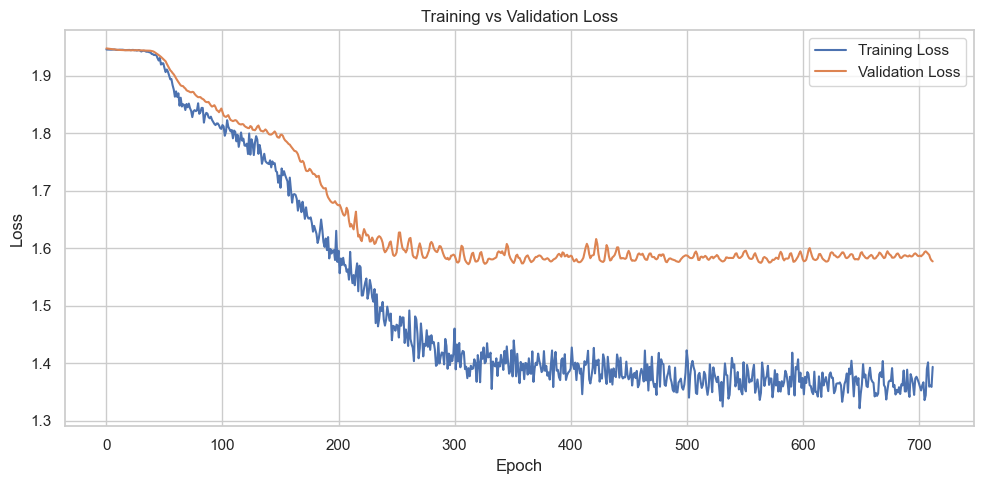

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure seaborn uses a clean style
sns.set(style="whitegrid")

# Convert training losses from torch tensors to float, if needed
#train_losses = [float(loss.cpu().detach().numpy()) for loss in losses]

# X-axis: epoch numbers
epochs = list(range(len(train_losses)))

# Create the plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=epochs, y=train_losses, label="Training Loss")
sns.lineplot(x=epochs, y=val_losses, label="Validation Loss")

# Add labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

Calculate test metric

In [14]:
model.load_state_dict(torch.load(best_val_model_path, weights_only=True))
test_loss, test_acc = evaluate()
print(f'Test Accuracy: {test_acc:.4f}\nTest Loss: {test_loss:.4f}')

Test Accuracy: 0.6310
Test Loss: 1.5722


torch.Size([2708, 7])


<Axes: >

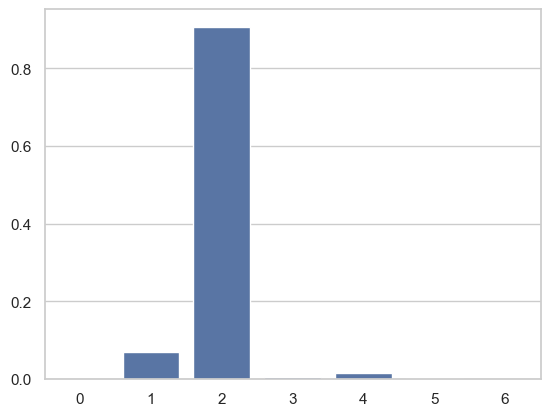

In [15]:
import seaborn as sns
import numpy as np
sample = 9
sns.set_theme(style="whitegrid")
print(model(data.x, data.edge_index).shape)
pred = model(data.x, data.edge_index)
sns.barplot(x=np.array(range(7)), y=pred[sample].detach().cpu().numpy())

### Visualizing the embeddings

/Users/matteogiorgi/Github/GNN_Notebooks/.env/lib/python3.11/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


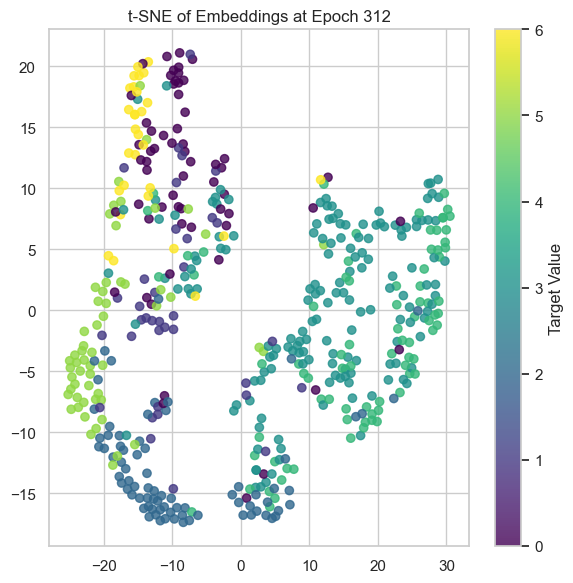

In [16]:
# Function for visualize the embedding
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_embeddings(embeddings, targets, epoch):
    # Convert to numpy
    emb = embeddings.cpu().detach().numpy()
    y = targets.cpu().detach().numpy()

    # Reduce to 2D
    tsne = TSNE(n_components=2, random_state=42)
    emb_2d = tsne.fit_transform(emb)

    # Plot
    plt.figure(figsize=(6, 6))
    sc = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=y, cmap='viridis', alpha=0.8)
    plt.colorbar(sc, label='Target Value')
    plt.title(f"t-SNE of Embeddings at Epoch {epoch}")
    plt.tight_layout()
    plt.show()
    
model.load_state_dict(torch.load(best_val_model_path, weights_only=True))
with torch.no_grad():
    model.eval()
    embedding = model(data.x.float(), data.edge_index, return_embedding=True)

plot_embeddings(embedding[data.val_mask], data.y[data.val_mask], best_epoch)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import imageio
import os

def plt2arr(fig):
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    renderer = fig.canvas.get_renderer()
    rgb = np.frombuffer(renderer.buffer_rgba(), dtype=np.uint8)
    arr = rgb.reshape((h, w, 4))[..., :3]
    return arr

def visualize(out, color, epoch):
    fig = plt.figure(figsize=(5,5), frameon=False)
    fig.suptitle(f'Epoch = {epoch}')
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color.detach().cpu().numpy(), cmap="Set2")
    fig.canvas.draw()
    arr = plt2arr(fig)
    plt.close(fig)
    return arr

# Reset the previously trained model weights
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

GIF saved to ./Colab Notebooks/GNN/best_val_model.gif


In [26]:
# Ignore deprecation warnings here
import warnings
warnings.filterwarnings('ignore')

# Train the model and save visualizations
images = []
for epoch in range(0, 1000):
    loss = train()
    if epoch % 50 == 0:
      out = model(data.x, data.edge_index)
      images.append(visualize(out, color=data.y, epoch=epoch))
print("TSNE Visualization finished.")

# Salva la GIF nel path del best_val_model
gif_path = os.path.join(GNN_PATH, 'Cora/embeddings_evol.gif')
imageio.mimsave(gif_path, images, duration=0.7)
print(f"GIF saved to {gif_path}")

KeyboardInterrupt: 

<Figure size 500x500 with 0 Axes>

## Improving the model
- Cross-Validation
- Hyperparameter Optimization
- Different layer types GCN, GAT... ([here](hhttps://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html))
- Including edge features ([here](https://wiki.tum.de/display/dlma/Exploiting+Edge+Features+in+Graph+Neural+Networks))  
--> The best performance is currently [at around 0.9](https://paperswithcode.com/sota/node-classification-on-cora)

### Hyperparameter optimization with Optuna

In [19]:
import optuna
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.nn import Linear

# Define GCN model with dropout
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, dropout):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, dataset.num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return F.softmax(self.out(x), dim=1)

In [20]:
# Objective function for Optuna
def objective(trial):
    hidden_channels = trial.suggest_categorical("hidden_channels", [16, 32, 64])
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.7)

    model = GCN(hidden_channels, dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = torch.nn.CrossEntropyLoss()

    def train():
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    def evaluate(mask):
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            loss = loss_fn(out[mask], data.y[mask])
            pred = out.argmax(dim=1)
            acc = (pred[mask] == data.y[mask]).sum().item() / int(mask.sum())
        return loss.item(), acc

    for epoch in range(300):
        train()

    val_loss, _ = evaluate(data.val_mask)
    trial.set_user_attr("final_model", model.state_dict())  # Save best model
    return val_loss  # We want to minimize validation loss

In [21]:
# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2025-07-30 22:09:54,742] A new study created in memory with name: no-name-b94dde7e-0e7a-489d-818e-90ef4d3d9994


[I 2025-07-30 22:09:58,318] Trial 0 finished with value: 1.4348844289779663 and parameters: {'hidden_channels': 16, 'lr': 0.004873873787393043, 'weight_decay': 2.149684865877048e-05, 'dropout': 0.08890590161068232}. Best is trial 0 with value: 1.4348844289779663.
[I 2025-07-30 22:10:02,481] Trial 1 finished with value: 1.9311336278915405 and parameters: {'hidden_channels': 16, 'lr': 0.0003738656181497225, 'weight_decay': 8.117935649350895e-05, 'dropout': 0.44849986980265233}. Best is trial 0 with value: 1.4348844289779663.
[I 2025-07-30 22:10:02,481] Trial 1 finished with value: 1.9311336278915405 and parameters: {'hidden_channels': 16, 'lr': 0.0003738656181497225, 'weight_decay': 8.117935649350895e-05, 'dropout': 0.44849986980265233}. Best is trial 0 with value: 1.4348844289779663.
[I 2025-07-30 22:10:06,422] Trial 2 finished with value: 1.9379299879074097 and parameters: {'hidden_channels': 16, 'lr': 0.00023409120290094783, 'weight_decay': 8.425010944872088e-05, 'dropout': 0.20177740

In [22]:
# Load best model and evaluate on the test set
best_params = study.best_params
best_model = GCN(best_params["hidden_channels"], best_params["dropout"]).to(device)
best_model.load_state_dict(study.best_trial.user_attrs["final_model"])

def test_results():
    best_model.eval()
    loss_fn = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        out = best_model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        test_loss = loss_fn(out[data.test_mask], data.y[data.test_mask]).item()
        test_acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / int(data.test_mask.sum())
    return test_loss, test_acc

test_loss, test_acc = test_results()

print("Best hyperparameters:", best_params)
print(f"Validation loss: {study.best_value:.4f}")
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Best hyperparameters: {'hidden_channels': 32, 'lr': 0.005143432847849014, 'weight_decay': 2.731193588971024e-06, 'dropout': 0.27272116739037405}
Validation loss: 1.4034
Test loss: 1.4077
Test accuracy: 0.7690


### GAT model

In [23]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads=8, dropout=0.5):
        super(GAT, self).__init__()

        self.dropout = dropout

        # First GAT layer: output shape will be [num_nodes, hidden_channels]
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=heads,
                             concat=True, dropout=dropout)
        
        # Second GAT layer: concat=False means we average heads,
        # output shape will be [num_nodes, hidden_channels]
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1,
                             concat=False, dropout=dropout)

        self.out = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, return_embedding=False):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        if return_embedding:
            return x

        return F.softmax(self.out(x), dim=1)

model = GAT(hidden_channels=8, heads=8, dropout=0.6)
print(model)
print("Number of parameters:", sum(p.numel() for p in model.parameters()))

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 8, heads=1)
  (out): Linear(in_features=8, out_features=7, bias=True)
)
Number of parameters: 92503


Execute training again